In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm
from datetime import datetime
import tqdm
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
%cd ..

/Users/yuqingwang/Desktop/Time Series Final


### Read the price data

In [3]:
price_dict = {"AMZN":1757.5,"FB":197.5,"EA":105,"NFLX":305,"ADBE":325}
expire_time = "2019/12/20 16:00"
expire_time = datetime.strptime(expire_time,"%Y/%m/%d %H:%M")
# data = pd.DataFrame()
# for i in range(11):
#     tmp = pd.read_excel("DATA.xlsx",sheet_name=i,index_col=0)
#     tmp.sort_index(ascending=True,inplace=True)
#     try: tmp = tmp["Close"]
#     except: tmp = tmp["Last Price"]
#     data = pd.concat([data,tmp],axis=1)
# data.columns = ["AMZN_OPT","AMZN","rf","FB","FB_OPT","EA","EA_OPT","NFLX","NFLX_OPT","ADBE","ADBE_OPT"]
# data.to_csv("data_cleaned.csv")

In [4]:
%cd data

/Users/yuqingwang/Desktop/Time Series Final/data


In [5]:
data = pd.read_csv("data_cleaned.csv",index_col=0)
data.tail()

,AMZN_OPT,AMZN,rf,FB,FB_OPT,EA,EA_OPT,NFLX,NFLX_OPT,ADBE,ADBE_OPT
2019/12/16 10:50,14.60,1760.2500,1.8713,198.3500,2.52,105.340,NaN,304.4200,3.61,324.605,2.48
2019/12/16 11:00,15.90,1763.5000,1.8748,198.1668,2.37,105.260,1.19,305.3000,4.10,324.670,2.70
2019/12/16 11:10,15.70,1762.2100,1.8818,197.6800,2.13,105.360,1.23,304.9263,4.00,324.140,2.30
2019/12/16 11:20,15.35,1761.5074,1.8818,197.7500,2.21,105.537,1.34,304.5448,3.60,324.410,2.65
2019/12/16 11:30,15.11,1760.6401,1.8801,197.2556,1.95,105.400,1.28,304.9036,3.81,324.435,2.58


### Select the 10 min option trade data

In [6]:
opt_data = data[["AMZN_OPT","FB_OPT","EA_OPT","NFLX_OPT","ADBE_OPT"]].dropna(how="all").join(data[["rf"]],how="inner").join(data[["AMZN","FB","EA","NFLX","ADBE"]])
opt_data.head()

,AMZN_OPT,FB_OPT,EA_OPT,NFLX_OPT,ADBE_OPT,rf,AMZN,FB,EA,NFLX,ADBE
2019/10/30 9:30,NaN,NaN,0.53,6.56,NaN,1.8191,1762.0000,187.7200,93.630,286.9500,274.105
2019/10/30 9:40,NaN,NaN,0.60,6.96,NaN,1.8103,1768.6140,188.4900,94.210,288.7200,274.365
2019/10/30 9:50,NaN,NaN,0.56,NaN,NaN,1.8138,1766.4446,188.1050,93.140,289.1200,274.015
2019/10/30 10:00,NaN,NaN,0.46,7.24,NaN,1.8138,1766.4600,187.8081,92.770,287.8700,273.870
2019/10/30 10:10,NaN,NaN,0.45,NaN,NaN,1.8120,1768.1724,187.9650,93.085,288.8869,273.430


### Calculate the implied volitality of options

In [7]:
def black_scholes(s,k,rf,t,sigma):
    d1 = (np.log(s/k)+(rf+0.5*sigma**2)*t)/(sigma*np.sqrt(t))
    d2 = d1 - sigma*np.sqrt(t)
    p = s*norm.cdf(d1)-k*np.exp(-rf*t)*norm.cdf(d2)
    return p

def get_delta(s,k,rf,t,sigma):
    d1 = (np.log(s/k)+(rf+0.5*sigma**2)*t)/(sigma*np.sqrt(t))
    return norm.cdf(d1)
    
def price_diff(args,s,k,rf,p,t):
    sigma = args[0]
    p_bs = black_scholes(s,k,rf,t,sigma)
    return abs(p-p_bs)

def get_implied_volitality(s,k,rf,p,t):
    sigma_0 = 0.2
    res = minimize(price_diff, [sigma_0],(s,k,rf,p,t) , method = "nelder-mead",
                options={"xtol": 1e-8, "disp": False, "maxiter": 1000})
    return res.x[0],res.fun

def time_diff(t):
    t = datetime.strptime(t,"%Y/%m/%d %H:%M")
    tdiff = expire_time - t
    res = tdiff.days + tdiff.seconds/86400
    return res/365

In [8]:
implied_vol = pd.DataFrame(index=opt_data.index,columns=opt_data.columns[:5])
for col in tqdm.tqdm_notebook(implied_vol.columns):
    sname = col.split("_")[0]
    for row in implied_vol.index:
        p = opt_data.loc[row,col]
        if np.isnan(p):continue
        s = opt_data.loc[row,sname]
        k = price_dict[sname]
        rf = opt_data.loc[row,"rf"]/100
        t = time_diff(row)
        impvol, fun = get_implied_volitality(s,k,rf,p,t)
        if fun<0.01:implied_vol.loc[row,col] = impvol
        #print(s,k,rf,p,t,get_implied_volitality(s,k,rf,p,t))
implied_vol.to_csv("implied_vol.csv")

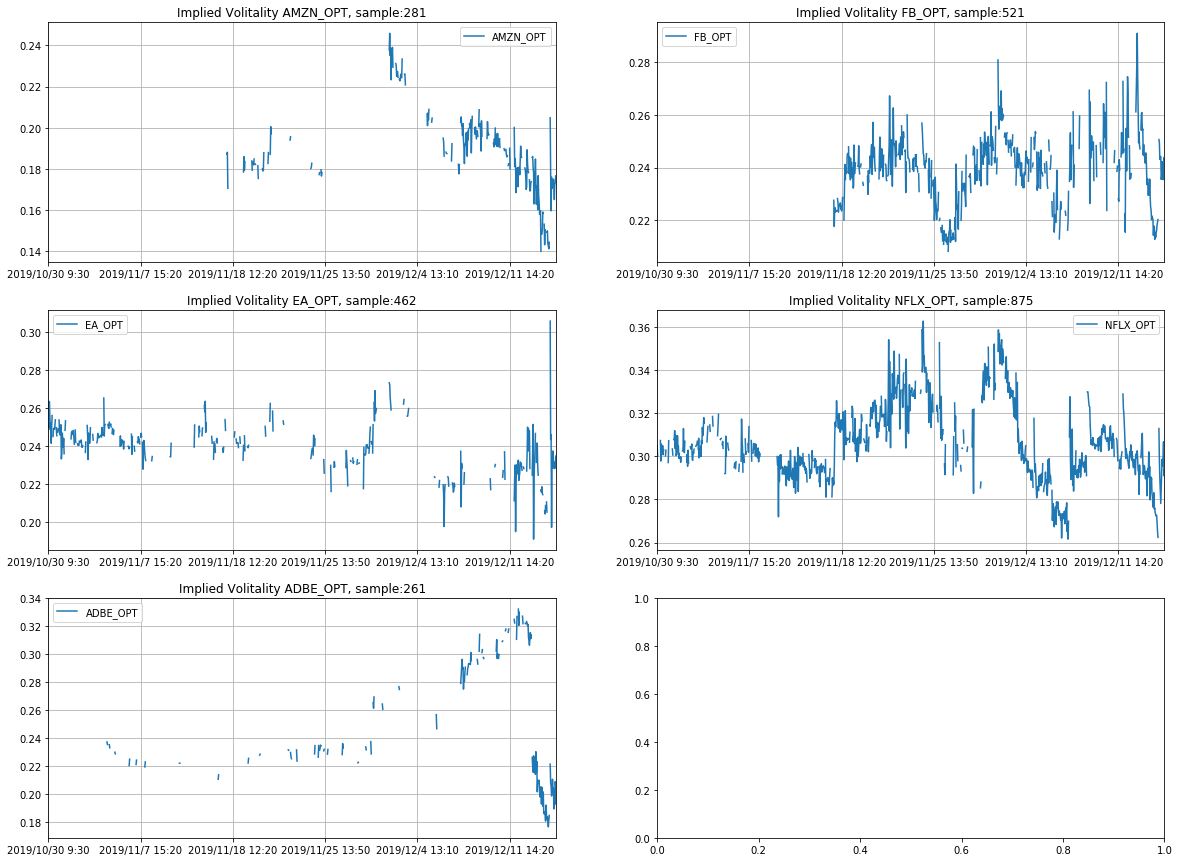

In [9]:
implied_vol = pd.read_csv("implied_vol.csv",index_col=0)
plt.subplots(3,2,figsize=(20,15))
for i,col in enumerate(implied_vol.columns):
    plt.subplot(3,2,i+1)
    implied_vol[col].plot()
    plt.grid()
    plt.legend()
    plt.title("Implied Volitality %s, sample:%d"%(col,len(implied_vol[col].dropna())))

We can see that AMZN and ADBE's options did not have much liquidity. So we did not use them in our trading strategy.

### Calculate the Delta of options

In [10]:
delta = pd.DataFrame(index=opt_data.index,columns=opt_data.columns[:5])
for col in tqdm.tqdm_notebook(delta.columns):
    sname = col.split("_")[0]
    for row in delta.index:
        impvol = implied_vol.loc[row,col]
        if np.isnan(impvol):continue
        p = opt_data.loc[row,col]
        s = opt_data.loc[row,sname]
        k = price_dict[sname]
        rf = opt_data.loc[row,"rf"]/100
        t = time_diff(row)
        delta.loc[row,col] = get_delta(s,k,rf,t,impvol)
        #print(s,k,rf,p,t,get_implied_volitality(s,k,rf,p,t))
delta.to_csv("delta.csv")

### Trade options according to forecasted volitality

We used 4 different models to estimate volatility, they are, ARCH model, GARCH model, IGARCH model and TGARCH model. In this part, we tried to used the best model we get to form a trading strategy. We did not trade on AMZN and ADBE's options since they have not enough liquidity.We select the best model for each stock during our backtest.


In [11]:
def backtest(stk,model):
    p_vol = pd.read_pickle("./Estimated Volatility/EA_%s_estimated_vol.pkl"%model)

    def get_predicted(idx):
        res = []
        for i in idx:
            res.append(p_vol.loc[i[0:10].replace("/","-")].values[0])
        return res

    
    def trade(stk):
        tmp = implied_vol[[stk+"_OPT"]].dropna()
        tmp = tmp.join(opt_data[stk+"_OPT"].dropna(),how="left",rsuffix="_price").join(opt_data[stk]).join(delta[stk+"_OPT"],rsuffix="_delta")
        tmp["predicted_vol"] = get_predicted(tmp.index)
        tmp["diff"] = tmp[stk+"_OPT"] - tmp["predicted_vol"]
        return tmp

    tmp = trade(stk)
    tmp_delta = tmp[stk+"_OPT_delta"]
    plt.subplots(1,2,figsize=(20,5))
    plt.subplot(1,2,1)
    tmp["%s_OPT"%stk].plot()
    tmp["predicted_vol"].plot()
    plt.grid()
    plt.legend()
    plt.title("Implied Volatility & Predicted Volatility, 10 min freq")
    tmp.index = pd.to_datetime(tmp.index)
    tmp = tmp.resample("1D").mean().dropna()
    plt.subplot(1,2,2)
    tmp["%s_OPT"%stk].plot()
    tmp["predicted_vol"].plot()
    plt.grid()
    plt.legend()
    plt.title("Implied Volatility & Predicted Volatility, 1 day freq")
    tmp_delta.index = pd.to_datetime(tmp_delta.index)
    tmp_delta = tmp_delta.resample("1D").sum()/tmp_delta.resample("1D").count()
    tmp["delta"] = tmp_delta.dropna()
    
    # trade 
    action = [0]
    state = 0
    snumber = []
    for r,i in enumerate(tmp["diff"]):
        if i>0 and state==0:
            action.append(-1)
            state = -1
            snumber.append(tmp["delta"][r])
        elif i<0 and state==0:
            action.append(1)
            state = 1
            snumber.append(-tmp["delta"][r])
        elif state==-1 and i<0:
            action.append(1)
            state = 0
            snumber.append(snumber[-1])
        elif state==1 and i>0:
            action.append(-1)
            state = 0
            snumber.append(snumber[-1])
        else:
            action.append(0)
            snumber.append(snumber[-1])
    tmp["action"] = action[1:]
    tmp["snumber"] = snumber
    tmp = tmp[tmp["action"]!=0]
    
    # pnl
    if len(tmp)%2 == 1:tmp=tmp.iloc[:-1,:]
    res_h = []
    for i in range(1,len(tmp),2):
        opt = -tmp[stk+"_OPT_price"][i]*tmp["action"][i]-tmp[stk+"_OPT_price"][i-1]*tmp["action"][i-1]
        stock = (tmp[stk][i]-tmp[stk][i-1])*tmp["snumber"][i]
        res_h.append(opt+stock)
    
    return res_h

In [12]:
def show_backtest_result():
    res_ea = backtest("EA","IGARCH")
    res_fb = backtest("FB","IGARCH")
    res_nflx = backtest("NFLX","ARCH")
    res_ea.extend(res_fb)
    res_ea.extend(res_nflx)
    print("cumulative return of the strategy:",round(sum(res_ea),3))
    print("average return of the strategy:",round(np.mean(res_ea),3))
    print("total trade:",len(res_ea))

In [13]:
%cd ..

/Users/yuqingwang/Desktop/Time Series Final


In [ ]:
show_backtest_result()